In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import date
import datetime as dt
import tensorflow as tf
import keras
from keras.layers import Input,Dropout,Dense,LSTM,TimeDistributed,RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.preprocessing import StandardScaler

In [104]:
class DataPreprocessor:
    def __init__(self, data_path):
        self.data_path = data_path
        self.df = pd.read_csv(self.data_path)
        self.df = self.df.drop(self.df.columns[0], axis=1)
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.train_data = None
        self.test_data = None
        self.analog_train = None
        self.analog_test = None
        self.digital_train = None
        self.digital_test = None

    def preprocessing_df(self):
        # create a new column where 1 day before the timeframe as well as the timeframe indicated in the paper is labeled as unhealthy data i.e. 1
        # healthy data is set as 0
        self.df['is_anomaly'] = np.where(
            ((self.df['timestamp'] >= "2020-04-11 11:50:00") & (self.df['timestamp'] <= "2020-04-12 23:30:00")) |
            ((self.df['timestamp'] >= "2020-04-17 00:00:00") & (self.df['timestamp'] <= "2020-04-19 01:30:00")) |
            ((self.df['timestamp'] >= "2020-04-28 03:20:00") & (self.df['timestamp'] <= "2020-04-29 22:20:00")) |
            
            
            ((self.df['timestamp'] >= "2020-05-12 14:00:00") & (self.df['timestamp'] <= "2020-05-13 23:59:00")) |
            ((self.df['timestamp'] >= "2020-05-17 05:00:00") & (self.df['timestamp'] <= "2020-05-20 20:00:00")) |
            
            
            ((self.df['timestamp'] >= "2020-05-28 23:30:00") & (self.df['timestamp'] <= "2020-05-30 06:00:00")) |
            
            ((self.df['timestamp'] >= "2020-05-31 15:00:00") & (self.df['timestamp'] <= "2020-06-01 15:40:00")) |
            ((self.df['timestamp'] >= "2020-06-02 10:00:00") & (self.df['timestamp'] <= "2020-06-03 11:00:00")) |
            ((self.df['timestamp'] >= "2020-06-04 10:00:00") & (self.df['timestamp'] <= "2020-06-07 14:30:00")) |
            
            ((self.df['timestamp'] >= "2020-07-07 17:30:00") & (self.df['timestamp'] <= "2020-07-08 19:00:00")) |
            ((self.df['timestamp'] >= "2020-07-14 14:30:00") & (self.df['timestamp'] <= "2020-07-15 19:00:00")) |
            ((self.df['timestamp'] >= "2020-07-16 04:30:00") & (self.df['timestamp'] <= "2020-07-17 05:30:00"))
            ,
            1, 0
        )
        self.data_path = "dataset_train_processed.csv" # change this path accordingly when you want to change the file location
        self.df.to_csv(self.data_path)
        self.df = pd.read_csv(self.data_path)

    def preprocessing_autoencoder(self):
        # self.train_data = self.df[
        #     (self.df['timestamp'] >= "2022-01-01 06:00:00") & (self.df['timestamp'] <= "2022-02-28 02:00:00")]
        # self.test_data = self.df[
        #     (self.df['timestamp'] >= "2022-02-28 06:00:00")]
        self.train_data = self.df[
            (self.df['timestamp'] >= "2020-02-01 00:00:00") & (self.df['timestamp'] < "2020-05-31 11:59:59") & 
            (self.df['is_anomaly'] == 0)]
        self.test_data = self.df[
            (self.df['timestamp'] >= "2020-06-01 00:00:00") & (self.df['timestamp'] < "2020-07-31 11:59:59")]
        self.train_data.drop(self.train_data.columns[0], axis=1,
                             inplace=True)  # there is an additional unnecessary column created at index 0 from preprocessing.df that needs to be removed if preprocessing_df is called
        self.test_data.drop(self.test_data.columns[0], axis=1, inplace=True)
        scaler = StandardScaler() # standardising only the analog data, leaving the digital data as is
        self.analog_train = pd.DataFrame(scaler.fit_transform(self.train_data.iloc[:, 1:8]))
        self.digital_train = self.train_data.iloc[:, 8:16]
        self.analog_test = pd.DataFrame(scaler.transform(self.test_data.iloc[:, 1:8]))
        self.digital_test = self.test_data.iloc[:, 8:16]

    def preprocessing_arima(self):
        df = self.df
        columns = ["timestamp", "TP2"]
        df = df[columns]
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.resample("5T", on="timestamp").mean() # data can also be resampled to other timeframes: refer to pandas documentation for more info
        df = df.fillna(method="ffill")
        self.train_data = df[(df.index >= pd.to_datetime("2020-02-01 00:00:00")) & (df.index <= pd.to_datetime("2020-04-30 11:59:59"))]
        self.test_data = df[(df.index >= pd.to_datetime("2020-05-01 00:00:00")) & (df.index <= pd.to_datetime("2020-05-04 11:59:59"))] # change accordingly depending on your forecast timeframe

    def preprocessing_ma(self):
        columns = ["timestamp", "TP2"]
        self.df = self.df[columns]
        self.train_data = self.df[
            (self.df['timestamp'] >= "2020-02-01 00:00:00") & (self.df['timestamp'] <= "2020-04-30 11:59:59")]
        self.test_data = self.df[
            (self.df['timestamp'] >= "2020-05-01 00:00:00")]

In [105]:
def main():
    preprocessor = DataPreprocessor("MetroPT3(AirCompressor).CSV") # change this to the file path of the train dataset
    preprocessor.preprocessing_df()

if __name__ == "__main__":
    main()

In [106]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import keras.backend as K
from tensorflow import keras
from keras.models import Model, save_model
from keras.layers import Conv1D, Conv1DTranspose, Lambda, Reshape, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from tensorflow.python.framework.ops import disable_eager_execution

In [107]:
disable_eager_execution() # variational autoencoder will not work without this
# an alternative is to replace all instances of keras with tf.keras

In [108]:
class AutoencoderModels:

    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
        self.model = None
        self.hist = None

    def leaky_relu(self, x):  # to be used as the activation function of the output layer for the analog models; greatly reduces the loss value
        return tf.nn.leaky_relu(x, alpha=0.01)

    def sae_analog(self):  # both analog and digital sensors have 8 features/columns
        # Encoder portion
        input_layer = keras.Input(shape=(1, self.train_data.shape[1])) # shape of input is (no. of timesteps = 1, no. of features = 8) - same for all models
        hidden_1 = Conv1D(filters=32, padding="same", kernel_size=3, activation='relu')(input_layer)
        hidden_2 = Conv1D(filters=16, padding="same", kernel_size=3, activation='relu')(hidden_1)
        bottleneck = Conv1D(filters=6, padding="same", kernel_size=3, activation="relu", activity_regularizer=keras.regularizers.l1_l2(l1=0.005, l2=0.1))(hidden_2)
        #  activity_regularizer=keras.regularizers.l1_l2(l1=0.005, l2=0.1)
        # Decoder portion
        hidden_3 = Conv1DTranspose(filters=16, padding="same", kernel_size=3, activation='relu')(bottleneck)
        hidden_4 = Conv1DTranspose(filters=32, padding="same", kernel_size=3, activation='relu')(hidden_3)
        output_layer = Conv1DTranspose(filters=self.train_data.shape[1], padding="same", kernel_size=3,
                              activation=self.leaky_relu)(
            hidden_4)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss='mse') # loss function can also be set to RMSE, MAE etc. for parameter tuning
        callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        hist = model.fit(np.expand_dims(self.train_data, 1), np.expand_dims(self.train_data, 1), validation_split=0.2,
                         epochs=50, callbacks=[callback], batch_size=60)
        save_model(model, "sae_analog.h5")
        self.model = model
        self.hist = hist

    def sae_digital(self):
        # Encoder portion
        input_layer = keras.Input(shape=(1, self.train_data.shape[1]))
        hidden_1 = Conv1D(filters=32, padding="same", kernel_size=3, activation='relu')(input_layer)
        hidden_2 = Conv1D(filters=16, padding="same", kernel_size=3, activation='relu')(hidden_1)
        bottleneck = Conv1D(filters=6, padding="same", kernel_size=3, activation="relu")(hidden_2)

        # Decoder Portion
        hidden_3 = Conv1DTranspose(filters=16, padding="same", kernel_size=3, activation='relu')(bottleneck)
        hidden_4 = Conv1DTranspose(filters=32, padding="same", kernel_size=3, activation='relu')(hidden_3)
        output_layer = Conv1DTranspose(filters=self.train_data.shape[1], padding="same", kernel_size=3, activation="sigmoid")(
            hidden_4)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss='binary_crossentropy')
        callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        hist = model.fit(np.expand_dims(self.train_data, 1), np.expand_dims(self.train_data, 1), validation_split=0.2,
                         epochs=50, callbacks=[callback], batch_size=60)
        save_model(model, "sae_digital.h5")
        self.model = model
        self.hist = hist

    def vae_analog(self):

        def sampling(args):  # reparameterization trick used in VAE to sample data points from the latent space
            z_mean, z_log_var = args  # log variance instead of variance is better for data that is not assumed to have a normal distribution
            batch_size = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch_size, dim)) # is a normal distribution with mean 0, variance 1
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        def vae_loss(x_actual, x_decoded):
            reconstruction_loss = K.mean(K.square(x_actual - x_decoded)) # measures the ability of the VAE to reconstruct the input data accurately
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # measures the difference between the learned latent distribution and the distribution of the data
            return reconstruction_loss + kl_loss

        # Encoder portion
        input_layer = keras.Input(shape=(1, self.train_data.shape[1]))
        hidden_1 = Conv1D(filters=32, padding="same", kernel_size=3, activation='relu')(input_layer)
        hidden_2 = Conv1D(filters=16, padding="same", kernel_size=3, activation='relu')(hidden_1)
        z_mean = Conv1D(filters=6, padding="same", kernel_size=3, activation="linear")(hidden_2)
        z_log_var = Conv1D(filters=6, padding="same", kernel_size=3, activation="linear")(hidden_2)
        z = Lambda(sampling)([z_mean, z_log_var])  # this layer is the lower-dimensional representation of the input data learned from the sampling method i.e. the latent space
        # the combination of z_mean z_log_var and the sampling layer can be thought of as similar to the bottleneck layer in a traditional autoencoder

        # Decoder portion
        hidden_3 = Conv1DTranspose(filters=16, padding="same", kernel_size=3, activation='relu')(z)
        hidden_4 = Conv1DTranspose(filters=32, padding="same", kernel_size=3, activation='relu')(hidden_3)
        output_layer = Conv1DTranspose(filters=self.train_data.shape[1], padding="same", kernel_size=3,
                              activation=self.leaky_relu)(hidden_4)
        output_layer = GlobalAveragePooling1D()(output_layer)
        output_layer = Reshape((1, self.train_data.shape[1]))(output_layer)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss=vae_loss)
        callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        hist = model.fit(np.expand_dims(self.train_data, 1), np.expand_dims(self.train_data, 1), validation_split=0.2,
                         epochs=50, callbacks=[callback], batch_size=60)
        save_model(model,"vae_analog.h5")
        self.model = model
        self.hist = hist

    def vae_digital(self): # exact same architecture as vae_analog

        def sampling(args):
            z_mean, z_log_var = args
            batch_size = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch_size, dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        def vae_loss(x_actual, x_decoded):
            reconstruction_loss = K.mean(K.square(x_actual - x_decoded)) # measures the ability of the VAE to reconstruct the input data accurately
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # measures the difference between the learned latent distribution and the distribution of the data
            return reconstruction_loss + kl_loss

        # Encoder portion
        input_layer = keras.Input(shape=(1, self.train_data.shape[1]))
        hidden_1 = Conv1D(filters=32, padding="same", kernel_size=3, activation='relu')(input_layer)
        hidden_2 = Conv1D(filters=16, padding="same", kernel_size=3, activation='relu')(hidden_1)
        z_mean = Conv1D(filters=6, padding="same", kernel_size=3, activation="linear")(hidden_2)
        z_log_var = Conv1D(filters=6, padding="same", kernel_size=3, activation="linear")(hidden_2)
        z = Lambda(sampling)([z_mean, z_log_var])

        # Decoder portion
        hidden_3 = Conv1DTranspose(filters=16, padding="same", kernel_size=3, activation='relu')(z)
        hidden_4 = Conv1DTranspose(filters=32, padding="same", kernel_size=3, activation='relu')(hidden_3)
        output_layer = Conv1D(filters=self.train_data.shape[1], padding="same", kernel_size=3,
                              activation="sigmoid")(hidden_4)
        output_layer = GlobalAveragePooling1D()(output_layer)
        output_layer = Reshape((1, self.train_data.shape[1]))(output_layer)
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss=vae_loss)
        callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        hist = model.fit(np.expand_dims(self.train_data, 1), np.expand_dims(self.train_data, 1), validation_split=0.2,
                         epochs=50, callbacks=[callback], batch_size=60)
        save_model(model, "vae_digital.h5")
        self.model = model
        self.hist = hist

    def autoencoder_predict_digital(self):
        train_pred = self.model.predict(np.expand_dims(self.train_data, 1))
        print("Shape of train_pred before reshaping:", train_pred.shape)
        
        train_pred = np.reshape(train_pred, (len(train_pred), 8))
    
        test_pred = self.model.predict(np.expand_dims(self.test_data, 1))
        print("Shape of test_pred before reshaping:", test_pred.shape)
        test_pred = np.reshape(test_pred, (len(test_pred), 8))
        return train_pred, test_pred
    
    def autoencoder_predict_analog(self):
        train_pred = self.model.predict(np.expand_dims(self.train_data, 1))
        print("Shape of train_pred before reshaping:", train_pred.shape)
        
        train_pred = np.reshape(train_pred, (len(train_pred), 7))
    
        test_pred = self.model.predict(np.expand_dims(self.test_data, 1))
        print("Shape of test_pred before reshaping:", test_pred.shape)
        test_pred = np.reshape(test_pred, (len(test_pred), 7))
        return train_pred, test_pred

    def plot_losses(self):
        plt.plot(self.hist.history["loss"])
        plt.plot(self.hist.history["val_loss"])
        plt.title("Training/Validation Loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend(["training_loss", "validation_loss"])
        plt.show()

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data.drop(self.train_data.columns[0], axis=1,
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data.drop(self.test_data.columns[0], axis=1, inplace=True)


Train on 611779 samples, validate on 152945 samples
Epoch 1/50
611580/611779 [============================>.] - ETA: 0s - loss: 0.1697

C:\Users\vgupt\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


611779/611779 [==============================] - 139s 226us/sample - loss: 0.1696 - val_loss: 0.0833
Epoch 2/50
611779/611779 [==============================] - 135s 220us/sample - loss: 0.0207 - val_loss: 0.0299
Epoch 3/50
611779/611779 [==============================] - 145s 237us/sample - loss: 0.0108 - val_loss: 0.0286
Epoch 4/50
611779/611779 [==============================] - 150s 245us/sample - loss: 0.0081 - val_loss: 0.0243
Epoch 5/50
611779/611779 [==============================] - 120s 197us/sample - loss: 0.0068 - val_loss: 0.0208
Epoch 6/50
611779/611779 [==============================] - 124s 202us/sample - loss: 0.0065 - val_loss: 0.0207
Epoch 7/50
611779/611779 [==============================] - 127s 207us/sample - loss: 0.0060 - val_loss: 0.0196
Epoch 8/50
611779/611779 [==============================] - 141s 230us/sample - loss: 0.0054 - val_loss: 0.0186
Epoch 9/50
611779/611779 [==============================] - 172s 281us/sample - loss: 0.0051 - val_loss: 0.0166
Epo

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\1723690628.py:90: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model,"vae_analog.h5")
C:\Users\vgupt\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Shape of train_pred before reshaping: (764724, 1, 7)
Shape of test_pred before reshaping: (434794, 1, 7)
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1, 7)]               0         []                            
                                                                                                  
 conv1d_30 (Conv1D)          (None, 1, 32)                704       ['input_9[0][0]']             
                                                                                                  
 conv1d_31 (Conv1D)          (None, 1, 16)                1552      ['conv1d_30[0][0]']           
                                                                                                  
 conv1d_32 (Conv1D)          (None, 1, 6)                 294       ['conv1d_31[0][0]'

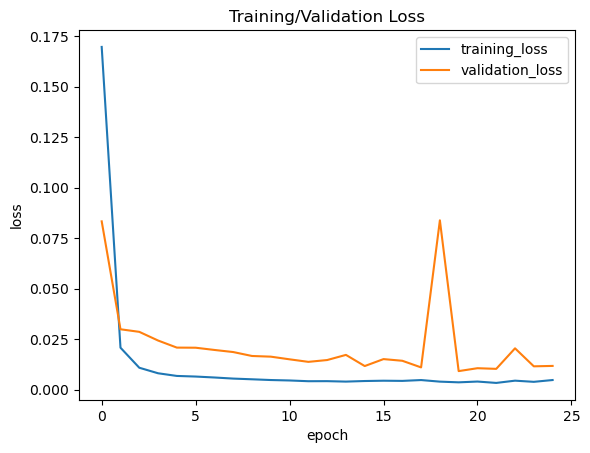

In [109]:
def main():
    preprocessor = DataPreprocessor("dataset_train_processed.csv") # change according to where your data is stored
    
    preprocessor.preprocessing_autoencoder()
    # autoencoder = AutoencoderModels(preprocessor.digital_train, preprocessor.digital_test) # comment out depending on whether digital/analog data is used
    autoencoder = AutoencoderModels(preprocessor.analog_train, preprocessor.analog_test)
    # autoencoder.sae_analog() # comment out according to which method you call from the AutoencoderModels class
    # autoencoder.vae_digital()
    autoencoder.vae_analog()
    # autoencoder.vae_digital()
    train_pred, test_pred = autoencoder.autoencoder_predict_analog()
    with open("vae_analog_train_pred", "wb") as file: # name of file path can change depending on where you want to save it
        pickle.dump(train_pred, file)
    with open("vae_analog_test_pred", "wb") as file: # similarly, this file path can be changed
        pickle.dump(test_pred, file)
    print(autoencoder.model.summary())
    autoencoder.plot_losses()

if __name__ == "__main__":
    main()

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data.drop(self.train_data.columns[0], axis=1,
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data.drop(self.test_data.columns[0], axis=1, inplace=True)


Train on 611779 samples, validate on 152945 samples
Epoch 1/50
611779/611779 [==============================] - ETA: 0s - loss: 0.0086

C:\Users\vgupt\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


611779/611779 [==============================] - 115s 189us/sample - loss: 0.0086 - val_loss: 0.0023
Epoch 2/50
611779/611779 [==============================] - 115s 188us/sample - loss: 8.9117e-04 - val_loss: 0.0024
Epoch 3/50
611779/611779 [==============================] - 116s 189us/sample - loss: 8.8156e-04 - val_loss: 0.0023
Epoch 4/50
611779/611779 [==============================] - 113s 185us/sample - loss: 0.0016 - val_loss: 0.0024
Epoch 5/50
611779/611779 [==============================] - 116s 189us/sample - loss: 0.0013 - val_loss: 0.0025
Epoch 6/50
611779/611779 [==============================] - 108s 176us/sample - loss: 0.0016 - val_loss: 0.0024
Epoch 7/50
611779/611779 [==============================] - 121s 199us/sample - loss: 0.0018 - val_loss: 0.0025
Epoch 8/50
611779/611779 [==============================] - 106s 173us/sample - loss: 0.0010 - val_loss: 0.0023


C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\1723690628.py:128: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, "vae_digital.h5")
C:\Users\vgupt\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Shape of train_pred before reshaping: (764724, 1, 8)
Shape of test_pred before reshaping: (434794, 1, 8)
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 1, 8)]               0         []                            
                                                                                                  
 conv1d_34 (Conv1D)          (None, 1, 32)                800       ['input_10[0][0]']            
                                                                                                  
 conv1d_35 (Conv1D)          (None, 1, 16)                1552      ['conv1d_34[0][0]']           
                                                                                                  
 conv1d_36 (Conv1D)          (None, 1, 6)                 294       ['conv1d_35[0][0]'

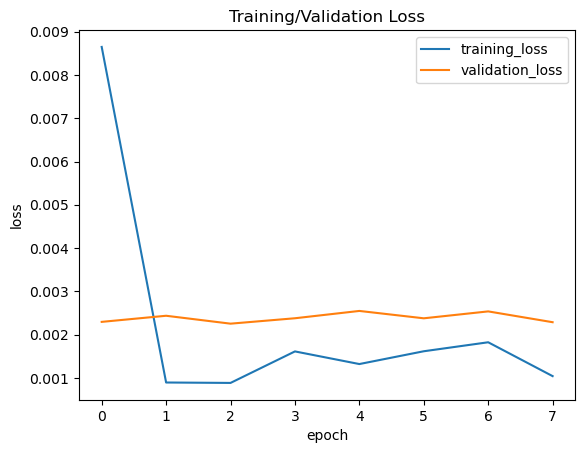

In [110]:
def main():
    preprocessor = DataPreprocessor("dataset_train_processed.csv") # change according to where your data is stored
    
    preprocessor.preprocessing_autoencoder()
    autoencoder = AutoencoderModels(preprocessor.digital_train, preprocessor.digital_test) # comment out depending on whether digital/analog data is used
    # autoencoder = AutoencoderModels(preprocessor.analog_train, preprocessor.analog_test)
    # autoencoder.sae_analog() # comment out according to which method you call from the AutoencoderModels class
    autoencoder.vae_digital()
    # autoencoder.vae_analog()
    # autoencoder.vae_digital()
    train_pred, test_pred = autoencoder.autoencoder_predict_digital()
    with open("vae_digital_train_pred", "wb") as file: # name of file path can change depending on where you want to save it
        pickle.dump(train_pred, file)
    with open("vae_digital_test_pred", "wb") as file: # similarly, this file path can be changed
        pickle.dump(test_pred, file)
    print(autoencoder.model.summary())
    autoencoder.plot_losses()

if __name__ == "__main__":
    main()

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data.drop(self.train_data.columns[0], axis=1,
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data.drop(self.test_data.columns[0], axis=1, inplace=True)


Train on 611779 samples, validate on 152945 samples
Epoch 1/50
611580/611779 [============================>.] - ETA: 0s - loss: 0.2201

C:\Users\vgupt\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


611779/611779 [==============================] - 89s 145us/sample - loss: 0.2201 - val_loss: 0.1396
Epoch 2/50
611779/611779 [==============================] - 114s 187us/sample - loss: 0.0753 - val_loss: 0.1127
Epoch 3/50
611779/611779 [==============================] - 125s 205us/sample - loss: 0.0536 - val_loss: 0.0905
Epoch 4/50
611779/611779 [==============================] - 118s 194us/sample - loss: 0.0479 - val_loss: 0.0792
Epoch 5/50
611779/611779 [==============================] - 116s 190us/sample - loss: 0.0314 - val_loss: 0.0528
Epoch 6/50
611779/611779 [==============================] - 87s 143us/sample - loss: 0.0239 - val_loss: 0.0498
Epoch 7/50
611779/611779 [==============================] - 102s 167us/sample - loss: 0.0220 - val_loss: 0.0475
Epoch 8/50
611779/611779 [==============================] - 108s 176us/sample - loss: 0.0184 - val_loss: 0.0409
Epoch 9/50
611779/611779 [==============================] - 94s 153us/sample - loss: 0.0142 - val_loss: 0.0383
Epoch 

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\1723690628.py:30: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, "sae_analog.h5")
C:\Users\vgupt\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Shape of train_pred before reshaping: (764724, 1, 7)
Shape of test_pred before reshaping: (434794, 1, 7)
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1, 7)]            0         
                                                                 
 conv1d_39 (Conv1D)          (None, 1, 32)             704       
                                                                 
 conv1d_40 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_41 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_27 (Conv1  (None, 1, 16)             304       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_2

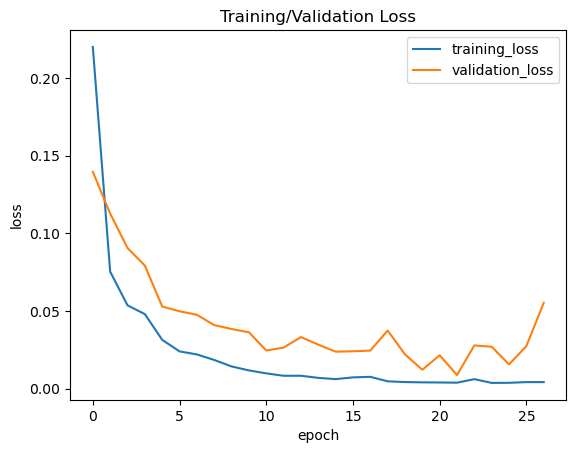

In [111]:
def main():
    preprocessor = DataPreprocessor("dataset_train_processed.csv") # change according to where your data is stored
    
    preprocessor.preprocessing_autoencoder()
    # autoencoder = AutoencoderModels(preprocessor.digital_train, preprocessor.digital_test) # comment out depending on whether digital/analog data is used
    autoencoder = AutoencoderModels(preprocessor.analog_train, preprocessor.analog_test)
    # autoencoder.sae_analog() # comment out according to which method you call from the AutoencoderModels class
    # autoencoder.vae_digital()
    autoencoder.sae_analog()
    # autoencoder.vae_digital()
    train_pred, test_pred = autoencoder.autoencoder_predict_analog()
    with open("sae_analog_train_pred", "wb") as file: # name of file path can change depending on where you want to save it
        pickle.dump(train_pred, file)
    with open("sae_analog_test_pred", "wb") as file: # similarly, this file path can be changed
        pickle.dump(test_pred, file)
    print(autoencoder.model.summary())
    autoencoder.plot_losses()

if __name__ == "__main__":
    main()

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data.drop(self.train_data.columns[0], axis=1,
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data.drop(self.test_data.columns[0], axis=1, inplace=True)


Train on 611779 samples, validate on 152945 samples
Epoch 1/50
611760/611779 [============================>.] - ETA: 0s - loss: 0.0099

C:\Users\vgupt\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


611779/611779 [==============================] - 98s 161us/sample - loss: 0.0099 - val_loss: 6.0755e-04
Epoch 2/50
611779/611779 [==============================] - 101s 166us/sample - loss: 4.1492e-04 - val_loss: 9.5020e-05
Epoch 3/50
611779/611779 [==============================] - 92s 151us/sample - loss: 1.7958e-04 - val_loss: 1.9379e-05
Epoch 4/50
611779/611779 [==============================] - 83s 136us/sample - loss: 1.2100e-04 - val_loss: 1.5300e-05
Epoch 5/50
611779/611779 [==============================] - 95s 155us/sample - loss: 7.7913e-05 - val_loss: 1.2726e-05
Epoch 6/50
611779/611779 [==============================] - 91s 149us/sample - loss: 4.2153e-05 - val_loss: 1.0703e-06
Epoch 7/50
611779/611779 [==============================] - 90s 147us/sample - loss: 1.9930e-05 - val_loss: 4.4568e-07
Epoch 8/50
611779/611779 [==============================] - 87s 142us/sample - loss: 3.2447e-05 - val_loss: 5.6217e-07
Epoch 9/50
611779/611779 [==============================] - 91

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\1723690628.py:51: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, "sae_digital.h5")
C:\Users\vgupt\AppData\Local\anaconda3\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Shape of train_pred before reshaping: (764724, 1, 8)
Shape of test_pred before reshaping: (434794, 1, 8)
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1, 8)]            0         
                                                                 
 conv1d_42 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_43 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_44 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_30 (Conv1  (None, 1, 16)             304       
 DTranspose)                                                     
                                                                 
 conv1d_transpose_3

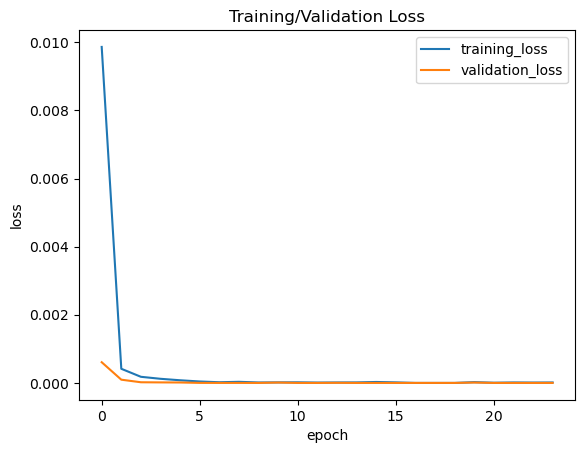

In [112]:
def main():
    preprocessor = DataPreprocessor("dataset_train_processed.csv") # change according to where your data is stored
    
    preprocessor.preprocessing_autoencoder()
    autoencoder = AutoencoderModels(preprocessor.digital_train, preprocessor.digital_test) # comment out depending on whether digital/analog data is used
    # autoencoder = AutoencoderModels(preprocessor.analog_train, preprocessor.analog_test)
    # autoencoder.sae_analog() # comment out according to which method you call from the AutoencoderModels class
    autoencoder.sae_digital()
    # autoencoder.vae_analog()
    # autoencoder.vae_digital()
    train_pred, test_pred = autoencoder.autoencoder_predict_digital()
    with open("sae_digital_train_pred", "wb") as file: # name of file path can change depending on where you want to save it
        pickle.dump(train_pred, file)
    with open("sae_digital_test_pred", "wb") as file: # similarly, this file path can be changed
        pickle.dump(test_pred, file)
    print(autoencoder.model.summary())
    autoencoder.plot_losses()

if __name__ == "__main__":
    main()

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [114]:
np.set_printoptions(suppress=True, precision=10)

In [122]:
class AutoencoderResults:
    def __init__(self, train_data, test_data, analog_train, analog_test, digital_train, digital_test):
        self.train_data = train_data
        self.test_data = test_data
        self.analog_train = analog_train
        self.analog_test = analog_test
        self.digital_train = digital_train
        self.digital_test = digital_test
        self.train_pred = None
        self.test_pred = None
        self.threshold = None

    def compute_error_sae_digital(self):
        with open("sae_digital_train_pred", "rb") as file:
            self.train_pred = pickle.load(file)
        with open("sae_digital_test_pred", "rb") as file:
            self.test_pred = pickle.load(file)
        reconstruction_error = np.mean(np.square(self.train_pred - self.digital_train), axis=1) # can try mse/rmse/mae etc.
        q1 = np.percentile(reconstruction_error, 25)
        q3 = np.percentile(reconstruction_error, 75)
        q9 = np.percentile(reconstruction_error, 99)
        self.threshold = q3 + 500000 * (q3 - q1)
        # self.threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)  # can be adjusted to find the optimal threshold
        test_error = np.mean(np.square(self.test_pred - self.digital_test), axis=1)
        print(q1)
        print(q3)
        print(max(reconstruction_error))
        print(min(test_error))
        q1_test = np.percentile(test_error, 25)
        q3_test = np.percentile(test_error, 75)
        q9_test = np.percentile(test_error, 99)
        print(q1_test)
        print(q3_test)
        print(q9_test)
        filtered_error = self.low_pass_filter(test_error,
                                         alpha=0.05)  # can be adjusted to find optimal alpha
        # predictions = [1 if error > self.threshold else 0 for error in filtered_error]
        predictions = [1 if error > 0.1 else 0 for error in filtered_error]
        self.test_data["predicted_output"] = predictions
        # pred_output = [0] * len(self.test_data)
        # for index in self.create_sequence(predictions):
        #     pred_output[index] = 1
        # self.test_data["predicted_output"] = pred_output
        # print(self.test_data["is_anomaly"].value_counts())
        # print(self.test_data["predicted_output"].value_counts())
        
    def compute_error_vae_digital(self):
        with open("vae_digital_train_pred", "rb") as file:
            self.train_pred = pickle.load(file)
        with open("vae_digital_test_pred", "rb") as file:
            self.test_pred = pickle.load(file)
        reconstruction_error = np.mean(np.square(self.train_pred - self.digital_train), axis=1) # can try mse/rmse/mae etc.
        q1 = np.percentile(reconstruction_error, 25)
        q3 = np.percentile(reconstruction_error, 75)
        self.threshold = q3 + 45000 * (q3 - q1)
        # self.threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)  # can be adjusted to find the optimal threshold
        test_error = np.mean(np.square(self.test_pred - self.digital_test), axis=1)
        
        filtered_error = self.low_pass_filter(test_error,
                                         alpha=0.05)  # can be adjusted to find optimal alpha
        predictions = [1 if error > self.threshold else 0 for error in filtered_error]
        self.test_data["predicted_output"] = predictions

    def compute_error_sae_analog(self):
        with open("sae_analog_train_pred", "rb") as file:
            self.train_pred = pickle.load(file)
        with open("sae_analog_test_pred", "rb") as file:
            self.test_pred = pickle.load(file)
        reconstruction_error = np.mean(np.square(self.train_pred - self.analog_train), axis=1) # can try mse/rmse/mae etc.
        q1 = np.percentile(reconstruction_error, 25)
        q3 = np.percentile(reconstruction_error, 75)
        #self.threshold = q3 + 2 * (q3 - q1)
        self.threshold = 0.122
        # self.threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)  # can be adjusted to find the optimal threshold
        test_error = np.mean(np.square(self.test_pred - self.analog_test), axis=1)
        filtered_error = self.low_pass_filter(test_error,
                                         alpha=0.1)  # can be adjusted to find optimal alpha
        predictions = [1 if error > self.threshold else 0 for error in filtered_error]
        self.test_data["predicted_output"] = predictions
    
    
    def compute_error_vae_analog(self):
        with open("vae_analog_train_pred", "rb") as file:
            self.train_pred = pickle.load(file)
        with open("vae_analog_test_pred", "rb") as file:
            self.test_pred = pickle.load(file)
        reconstruction_error = np.mean(np.square(self.train_pred - self.analog_train), axis=1) # can try mse/rmse/mae etc.
        q1 = np.percentile(reconstruction_error, 25)
        q3 = np.percentile(reconstruction_error, 75)
        self.threshold = q3 + 2 * (q3 - q1)
        # self.threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)  # can be adjusted to find the optimal threshold
        test_error = np.mean(np.square(self.test_pred - self.analog_test), axis=1)
        filtered_error = self.low_pass_filter(test_error,
                                         alpha=0.1)  # can be adjusted to find optimal alpha
        predictions = [1 if error > self.threshold else 0 for error in filtered_error]
        self.test_data["predicted_output"] = predictions
    
    
    def low_pass_filter(self, error, alpha): # test_error is passed through low_pass_filter to improve evaluation metrics
        error = error.reset_index(drop = True)
        output = [error[0]]  # initialize the output with the first input value
        for i in range(1, len(error)):
            output.append(output[i - 1] + alpha * (error[i] - output[i - 1]))
        return output

    def create_sequence(self, anomalies):  # check if anomaly data points appear consecutively
    # if a point appears by itself, it has a high chance of simply being random noise rather than a part of any failure
    # returns index of anomalies
        tmp1 = []
        tmp2 = []
        lst = []
        for i in range(len(anomalies)):
            if anomalies[i] == 1:
                tmp1.append(i)
        for j in range(len(tmp1) - 1):
            if tmp1[j] + 1 == tmp1[j + 1]:  # check if the next index is the same as the previous index + 1 (eg. 501 == 500 + 1)
                tmp2.append(tmp1[j])
            if tmp1[j + 1] != tmp1[j] + 1:
                if len(tmp2) >= 2:  # sequences have to be x seconds or more - can be adjusted to affect precision/recall
                    tmp2.append(tmp1[j])
                    lst.extend(tmp2)
                tmp2 = []
        return lst

    def plot_cm_SAE_Digital(self):
        cm = confusion_matrix(self.test_data["is_anomaly"], self.test_data["predicted_output"])
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        print(classification_report(self.test_data["is_anomaly"], self.test_data["predicted_output"]))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
        disp.plot(values_format='d', cmap="Reds")
        plt.title("Sparse Autoencoder - Digital (alpha=0.05)\nPrecision={:.2f}, Recall={:.2f}, F1 Score={:.2f}".format(precision, recall, f1_score))
        plt.show()
        
        
    def plot_cm_VAE_Digital(self):
        cm = confusion_matrix(self.test_data["is_anomaly"], self.test_data["predicted_output"])
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        print(classification_report(self.test_data["is_anomaly"], self.test_data["predicted_output"]))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
        disp.plot(values_format='d', cmap="Reds")
        plt.title("Variational Autoencoder - Digital (alpha=0.05)\nPrecision={:.2f}, Recall={:.2f}, F1 Score={:.2f}".format(precision, recall, f1_score))
        plt.show()
        
        
    def plot_cm_SAE_Analog(self):
        cm = confusion_matrix(self.test_data["is_anomaly"], self.test_data["predicted_output"])
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        print(classification_report(self.test_data["is_anomaly"], self.test_data["predicted_output"]))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
        disp.plot(values_format='d', cmap="Reds")
        plt.title("Sparse Autoencoder - Analog (alpha=0.05)\nPrecision={:.2f}, Recall={:.2f}, F1 Score={:.2f}".format(precision, recall, f1_score))
        plt.show()
        
        
    def plot_cm_VAE_Analog(self):
        cm = confusion_matrix(self.test_data["is_anomaly"], self.test_data["predicted_output"])
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        print(classification_report(self.test_data["is_anomaly"], self.test_data["predicted_output"]))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
        disp.plot(values_format='d', cmap="Reds")
        plt.title("Variational Autoencoder - Analog (alpha=0.05)\nPrecision={:.2f}, Recall={:.2f}, F1 Score={:.2f}".format(precision, recall, f1_score))
        plt.show()

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data.drop(self.train_data.columns[0], axis=1,
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data.drop(self.test_data.columns[0], axis=1, inplace=True)


6.048776725624281e-63
6.048776725624281e-63
4.022199743889668e-07
6.048776725624281e-63
6.048776725624281e-63
7.462884573302835e-57
0.125


C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\1706531485.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data["predicted_output"] = predictions


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    380974
           1       1.00      1.00      1.00     53820

    accuracy                           1.00    434794
   macro avg       1.00      1.00      1.00    434794
weighted avg       1.00      1.00      1.00    434794



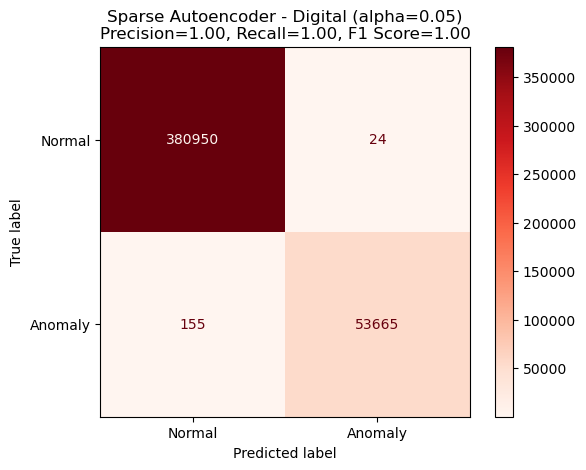

In [123]:
# sae_digital

def main():
    preprocessor = DataPreprocessor("dataset_train_processed.csv")
    preprocessor.preprocessing_autoencoder()
    autoencoder_results = AutoencoderResults(preprocessor.train_data, preprocessor.test_data, preprocessor.analog_train,
                                             preprocessor.analog_test, preprocessor.digital_train, preprocessor.digital_test)
    autoencoder_results.compute_error_sae_digital()
    autoencoder_results.plot_cm_SAE_Digital()


if __name__ == "__main__":
    main()

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data.drop(self.train_data.columns[0], axis=1,
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data.drop(self.test_data.columns[0], axis=1, inplace=True)
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\1706531485.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    380974
           1       0.71      1.00      0.83     53820

    accuracy                           0.95    434794
   macro avg       0.86      0.97      0.90    434794
weighted avg       0.96      0.95      0.95    434794



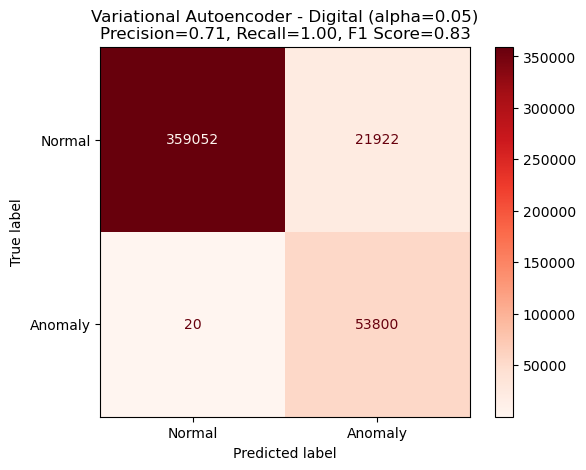

In [124]:
# vae_digital

def main():
    preprocessor = DataPreprocessor("dataset_train_processed.csv")
    preprocessor.preprocessing_autoencoder()
    autoencoder_results = AutoencoderResults(preprocessor.train_data, preprocessor.test_data, preprocessor.analog_train,
                                             preprocessor.analog_test, preprocessor.digital_train, preprocessor.digital_test)
    autoencoder_results.compute_error_vae_digital()
    autoencoder_results.plot_cm_VAE_Digital()


if __name__ == "__main__":
    main()

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data.drop(self.train_data.columns[0], axis=1,
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data.drop(self.test_data.columns[0], axis=1, inplace=True)
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\1706531485.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

              precision    recall  f1-score   support

           0       0.88      1.00      0.93    380974
           1       0.61      0.03      0.06     53820

    accuracy                           0.88    434794
   macro avg       0.74      0.51      0.50    434794
weighted avg       0.85      0.88      0.83    434794



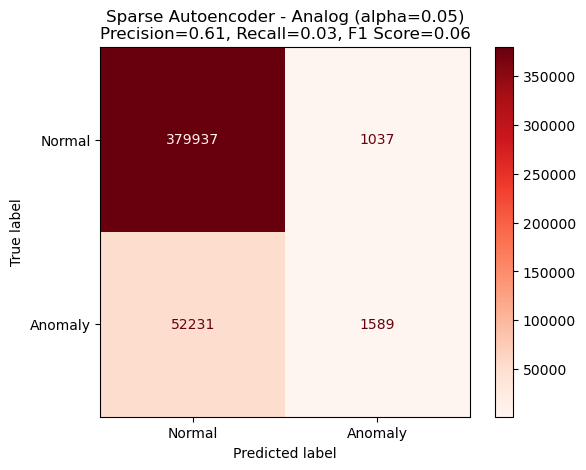

In [125]:
# sae_analog

def main():
    preprocessor = DataPreprocessor("dataset_train_processed.csv")
    preprocessor.preprocessing_autoencoder()
    autoencoder_results = AutoencoderResults(preprocessor.train_data, preprocessor.test_data, preprocessor.analog_train,
                                             preprocessor.analog_test, preprocessor.digital_train, preprocessor.digital_test)
    autoencoder_results.compute_error_sae_analog()
    autoencoder_results.plot_cm_SAE_Analog()


if __name__ == "__main__":
    main()

C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.train_data.drop(self.train_data.columns[0], axis=1,
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\2077362206.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.test_data.drop(self.test_data.columns[0], axis=1, inplace=True)
C:\Users\vgupt\AppData\Local\Temp\ipykernel_45544\1706531485.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

              precision    recall  f1-score   support

           0       0.93      0.82      0.87    380974
           1       0.31      0.59      0.41     53820

    accuracy                           0.79    434794
   macro avg       0.62      0.70      0.64    434794
weighted avg       0.86      0.79      0.81    434794



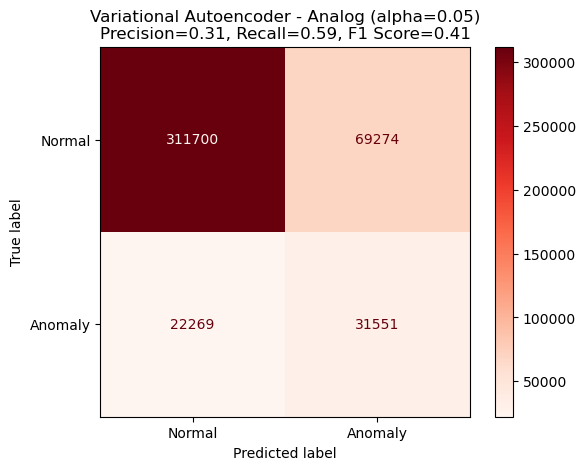

In [126]:
# vae_analog

def main():
    preprocessor = DataPreprocessor("dataset_train_processed.csv")
    preprocessor.preprocessing_autoencoder()
    autoencoder_results = AutoencoderResults(preprocessor.train_data, preprocessor.test_data, preprocessor.analog_train,
                                             preprocessor.analog_test, preprocessor.digital_train, preprocessor.digital_test)
    autoencoder_results.compute_error_vae_analog()
    autoencoder_results.plot_cm_VAE_Analog()


if __name__ == "__main__":
    main()